In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import acf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import mlflow 
import mlflow.pytorch
from datetime import datetime
import os

In [2]:
df = pd.read_csv('../data/ETTm1.csv')

In [3]:
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [4]:
df.describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,7.413993,2.261418,4.322226,0.896509,3.082888,0.857907,13.320642
std,7.082928,2.041293,6.829189,1.807239,1.174063,0.600440,8.564817
min,-23.242001,-5.693000,-26.367001,-6.041000,-1.188000,-1.371000,-4.221000
25%,5.827000,0.804000,3.305000,-0.284000,2.315000,0.670000,6.964000
50%,8.841000,2.210000,6.005000,0.959000,2.833000,0.975000,11.396000
75%,11.788000,3.684000,8.635000,2.203000,3.655000,1.218000,18.079000
max,24.180000,10.315000,18.087000,7.853000,8.498000,3.046000,46.007000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69680 entries, 0 to 69679
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    69680 non-null  object 
 1   HUFL    69680 non-null  float64
 2   HULL    69680 non-null  float64
 3   MUFL    69680 non-null  float64
 4   MULL    69680 non-null  float64
 5   LUFL    69680 non-null  float64
 6   LULL    69680 non-null  float64
 7   OT      69680 non-null  float64
dtypes: float64(7), object(1)
memory usage: 4.3+ MB


In [6]:
df['date'] = pd.to_datetime(df['date'])

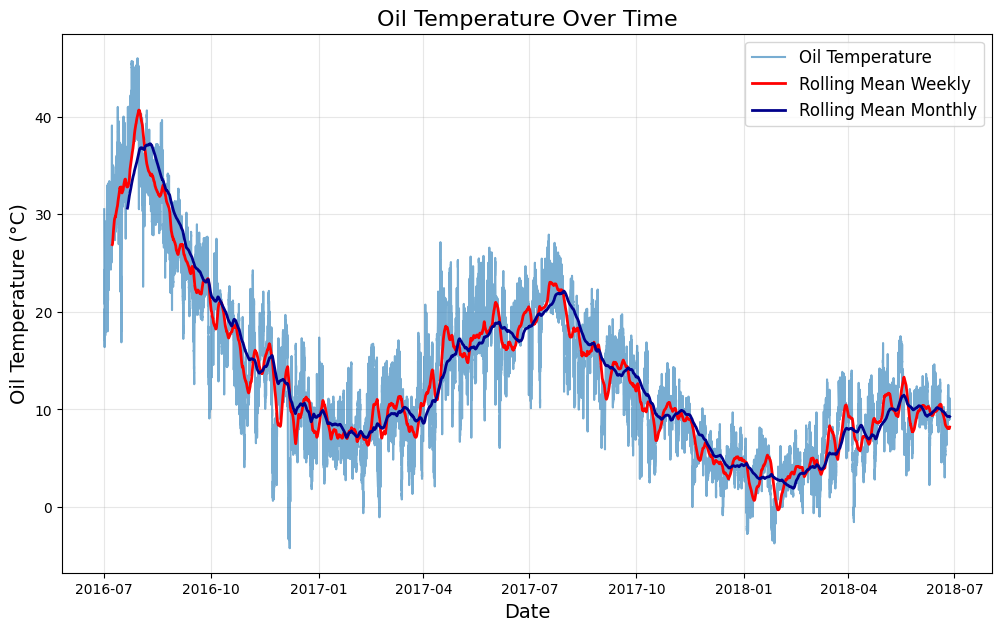

In [7]:
rolling_mean_week = df['OT'].rolling(window=4*24*7).mean() #weekly rolling window
rolling_mean_month = df['OT'].rolling(window=4*24*20).mean()


plt.figure(figsize=(12, 7))

plt.plot(df['date'], df['OT'], label='Oil Temperature', alpha=0.6)
plt.plot(df['date'], rolling_mean_week, label='Rolling Mean Weekly', color='red', linewidth=2)
plt.plot(df['date'], rolling_mean_month, label='Rolling Mean Monthly', color='darkblue', linewidth=2)


plt.title('Oil Temperature Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Oil Temperature (°C)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

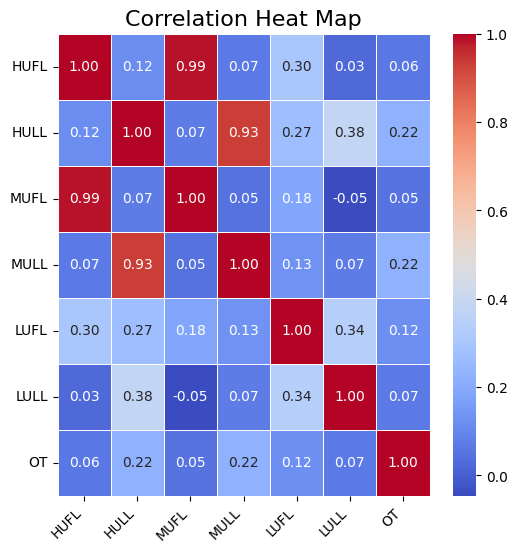

In [8]:
correlations = df.iloc[:,1:].corr()

plt.figure(figsize=(6, 6))  
sns.heatmap(
    correlations, 
    annot=True,        # Annotate cells with the correlation values
    fmt=".2f",         # Format for annotations
    cmap="coolwarm",   # Color map
    linewidths=0.5,    # Add gridlines
    cbar=True          # Show the color bar
)

plt.title("Correlation Heat Map", fontsize=16)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)               
plt.show()

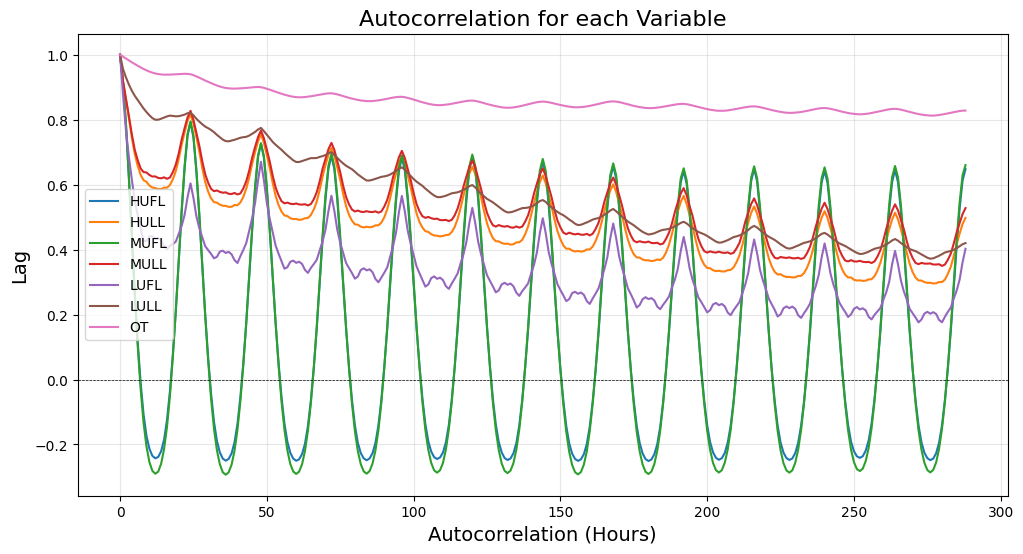

In [9]:
plt.figure(figsize=(12, 6))

for column in df.columns[1:]:
    var = df[column]
    var = var[::4]
    autocorr = acf(var, nlags=24*12)
    plt.plot(range(len(autocorr)), autocorr, label=column)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.xlabel('Autocorrelation (Hours)', fontsize=14)
plt.ylabel('Lag', fontsize=14)
plt.title('Autocorrelation for each Variable', fontsize=16)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [10]:
class ETDataset(Dataset):
    def __init__(self, df, sequence_length=24, targe_column = 'OT'):
        self.sequence_length = sequence_length
        
        feature_cols = df.drop([targe_column, 'date'], axis=1).columns
        self.features = df[feature_cols].values
        self.target = df[targe_column].values

        self.data = []
        self.pred = []

        for i in range(len(self.features) - sequence_length):
            self.data.append(self.features[i:i+sequence_length])
            self.pred.append(self.target[i+sequence_length])

        self.data = np.array(self.data, dtype=np.float32)
        self.pred = np.array(self.pred, dtype=np.float32)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32), torch.tensor(self.pred[index], dtype=torch.float32)

dataset = ETDataset(df)

In [11]:
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate lengths for each subset
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the split
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Training set size: 55724
Testing set size: 13932


In [12]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()

    def forward(self, x):
        return x[ -1 ,-1]

baseline_model = BaselineModel()
baseline_model(df.iloc[:1].values)

30.5310001373291

In [13]:
class SimpleRNN(nn.Module):
    def __init__(self, num_inputs, hidden_size, num_layers, dropout = 0):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=num_inputs,  hidden_size=hidden_size,num_layers=num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        _ , hidden = self.rnn(x)
        y = self.linear(hidden[-1])
        return y

In [14]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()

        #define weigths for reset gate
        self.reset_x = nn.Linear(input_size, hidden_size)
        self.reset_h = nn.Linear(hidden_size, hidden_size)

        #define weigths for update gate
        self.update_x = nn.Linear(input_size, hidden_size)
        self.update_h = nn.Linear(hidden_size, hidden_size)

        #define weigts for candidate hidden state
        self.candidate_x = nn.Linear(input_size, hidden_size)
        self.candidate_h = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        #reset gate
        r = F.sigmoid(self.reset_x(x) + self.reset_h(h))

        #update gate
        z = F.sigmoid(self.update_x(x) + self.update_h(h))

        #candidate hidden state
        h_snake = F.tanh(self.candidate_x(x) + self.candidate_h(r*h))

        h = z*h + (1-z)*h_snake

        return h
    
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUModel, self).__init__()
        self.gru_cell = GRUCell(input_size, hidden_size)
        self.regressor = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, x):
        sequence_length = x.shape[1]
        batch_size = x.shape[0]

        # Initialize the hidden state h_0
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Process the sequence step-by-step
        for t in range(sequence_length):
            x_t = x[:, t, :]  # Input at time step t
            h = self.gru_cell(x_t, h)  # Update hidden state

        # Use the final hidden state to compute the output
        output = self.regressor(h)  # Output shape: (batch_size, 1)
        return output

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

In [17]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('RNNs')

<Experiment: artifact_location='mlflow-artifacts:/759628241660649766', creation_time=1732035720778, experiment_id='759628241660649766', last_update_time=1732035720778, lifecycle_stage='active', name='RNNs', tags={}>

In [18]:
def train_model(model, train_loader, test_loader, epochs):

    if mlflow.active_run():
        print(f"Ending active run: {mlflow.active_run().info.run_id}")
        mlflow.end_run()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    plot_train_mse = []
    plot_val_mse = []

    current_time = datetime.now().strftime("%H:%M:%S")
    run_name = f"{model.__class__.__name__}_{current_time}"

    with mlflow.start_run(run_name=run_name) as run:

        mlflow.log_param('learning_rate', 1e-4)
        mlflow.log_param('batch_size', 32)
        mlflow.log_param('num_epochs', epochs)


        for epoch in range(epochs):
            running_loss = []
            test_loss = []

            model.train()
            for sequence, pred in train_loader:
                output = model(sequence)

                optimizer.zero_grad()
                loss = criterion(output.squeeze(), pred)
                loss.backward()
                optimizer.step()

                running_loss.append(loss.item())

            model.eval()
            for sequence, pred in test_loader:
                output = model(sequence)

                test_loss.append(criterion(output.squeeze(), pred).item())
            
            plot_train_mse.append(np.mean(running_loss))
            plot_val_mse.append(np.mean(test_loss))

            mlflow.log_metric('train_mse', np.mean(running_loss), step=epoch)
            mlflow.log_metric('val_mse',np.mean(test_loss), step=epoch)

            if (epoch) % 5 == 0:
                print(f'Epoch: {epoch+1} Training MSE: {np.mean(running_loss):.4f} Validation MSE: {np.mean(test_loss):.4f}')
    
    mlflow.pytorch.log_model(model, model.__class__.__name__)

    plt.plot(plot_train_mse, label = 'Training MSE')
    plt.plot(plot_val_mse, label = 'Validation MSE')
    plt.tight_layout()
    plt.legend()
    plt.title('Training graph')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(alpha = 0.3)
    plt.show()

    return model

Ending active run: 716ca112034a4cf0beb5d80377c8d5ca


2024/11/20 14:40:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-kite-113 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/716ca112034a4cf0beb5d80377c8d5ca.
2024/11/20 14:40:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.


Epoch: 1 Training MSE: 116.9357 Validation MSE: 76.1157
Epoch: 6 Training MSE: 68.5036 Validation MSE: 67.3760


2024/11/20 14:42:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run SimpleRNN_14:40:41 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/b0070b9aa4014f3f8be3864deab347b0.
2024/11/20 14:42:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 14:43:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


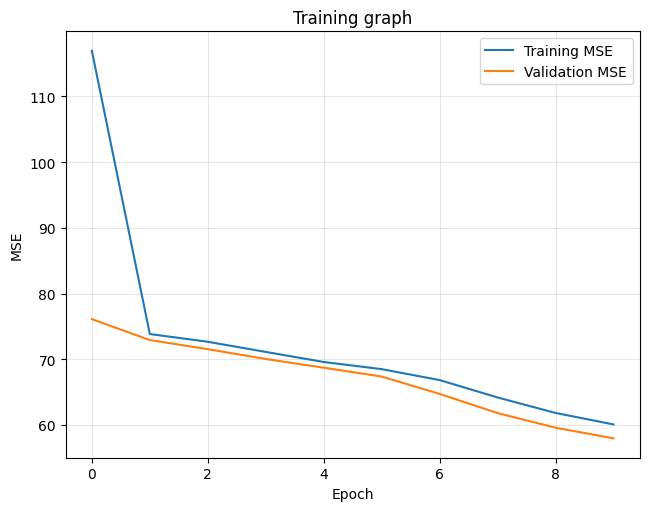

In [99]:
simple_model = SimpleRNN(len(df.columns)-2, 64, num_layers=1)
trained_model = train_model(simple_model, train_loader, test_loader, 10)

2024/11/20 14:43:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run bittersweet-crow-759 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/44808a53ed0240699b803910e488a408.
2024/11/20 14:43:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.


Ending active run: 44808a53ed0240699b803910e488a408
Epoch: 1 Training MSE: 167.3475 Validation MSE: 108.9107
Epoch: 6 Training MSE: 67.1392 Validation MSE: 66.0156


2024/11/20 14:56:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run GRUModel_14:43:06 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/0414ff22abdf4ccb9b6f0e4954664a00.
2024/11/20 14:56:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 14:57:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


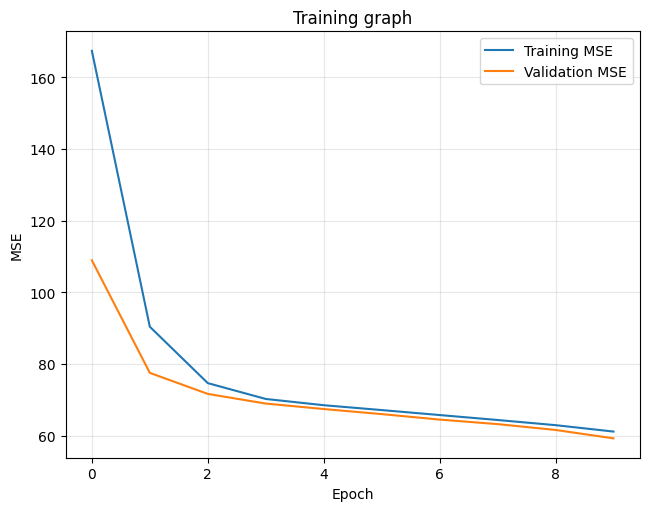

In [100]:
gru_model = GRUModel(6,32)
gru_model_trained = train_model(gru_model, train_loader, test_loader, 10)

2024/11/20 14:57:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run angry-gnat-836 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/8f077ee838054eb9a14429662b5f001d.
2024/11/20 14:57:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.


Ending active run: 8f077ee838054eb9a14429662b5f001d
Epoch: 1 Training MSE: 151.0046 Validation MSE: 94.8945
Epoch: 6 Training MSE: 68.2294 Validation MSE: 67.8396


2024/11/20 14:59:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run LSTMModel_14:57:06 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/f876eb5f9e144d04983d3066123712ee.
2024/11/20 14:59:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 14:59:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


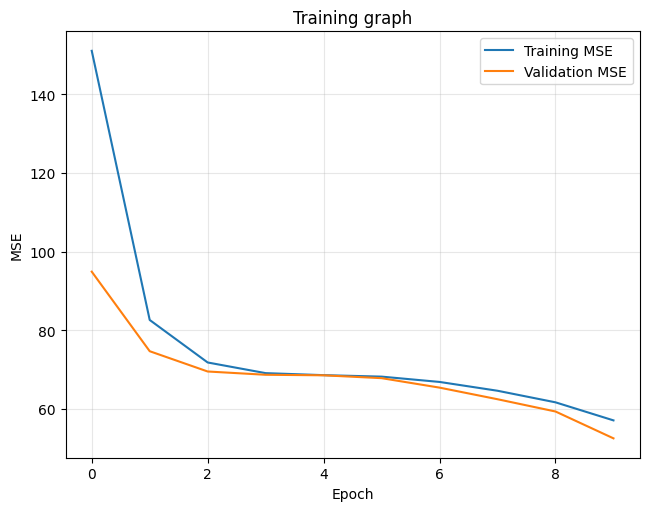

In [101]:
lstm_model = LSTMModel(6,32,num_layers=1)
trained_lstm = train_model(lstm_model, train_loader, test_loader, 10)

2024/11/20 14:59:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-swan-284 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/67972046a4cc4789b9dea371a1acd9ce.
2024/11/20 14:59:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.


Ending active run: 67972046a4cc4789b9dea371a1acd9ce
Epoch: 1 Training MSE: 104.3611 Validation MSE: 74.8286
Epoch: 6 Training MSE: 54.7943 Validation MSE: 54.5482


2024/11/20 15:07:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run SimpleRNN_14:59:52 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/5513dc87a9a440748cdbaf5255795ac0.
2024/11/20 15:07:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 15:08:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


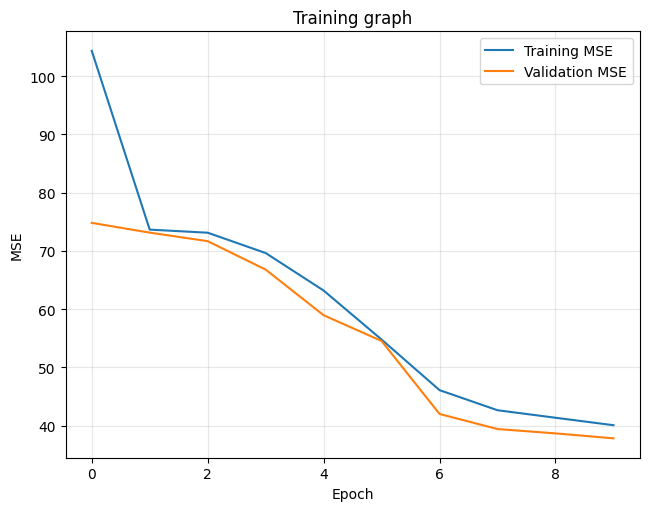

In [102]:
stackedRNN = SimpleRNN(len(df.columns)-2, 64, num_layers=3)
trained_stacked_rnn = train_model(stackedRNN, train_loader, test_loader, 10)

In [72]:
from transformers import BertConfig, BertModel

class TimeBERT(nn.Module):
    def __init__(self, input_dim, sequence_length, hidden_dim=128):
        super(TimeBERT, self).__init__()

        # BERT configuration
        self.bert_config = BertConfig(
            hidden_size=hidden_dim,
            num_attention_heads=4,
            num_hidden_layers=2,
            intermediate_size=hidden_dim * 4,
            max_position_embeddings=sequence_length,
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
        )
        self.bert = BertModel(self.bert_config)

        # Feature embedding
        self.feature_embed = nn.Linear(input_dim, hidden_dim)

        # Output layer
        self.regressor = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size, seq_len, input_dim = x.size()

        # Embed time-series features
        x = self.feature_embed(x)  # Shape: (batch_size, sequence_length, hidden_dim)

        # Reshape for BERT input
        x = x.view(batch_size, seq_len, -1)  # Shape: (batch_size, sequence_length, hidden_dim)

        # BERT encoding
        bert_output = self.bert(inputs_embeds=x)
        sequence_output = bert_output.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_dim)

        # Use the CLS token output (first token) for regression
        cls_output = sequence_output[:, 0, :]  # Shape: (batch_size, hidden_dim)

        # Regression head
        output = self.regressor(cls_output)  # Shape: (batch_size, 1)

        return output

Epoch: 1 Training MSE: 81.2389 Validation MSE: 64.7223
Epoch: 6 Training MSE: 36.6969 Validation MSE: 33.2767


2024/11/20 14:32:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run TimeBERT_14:21:45 at: http://127.0.0.1:5000/#/experiments/759628241660649766/runs/5c52225e3c8a420ea6d14a34f45d3711.
2024/11/20 14:32:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/759628241660649766.
2024/11/20 14:32:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


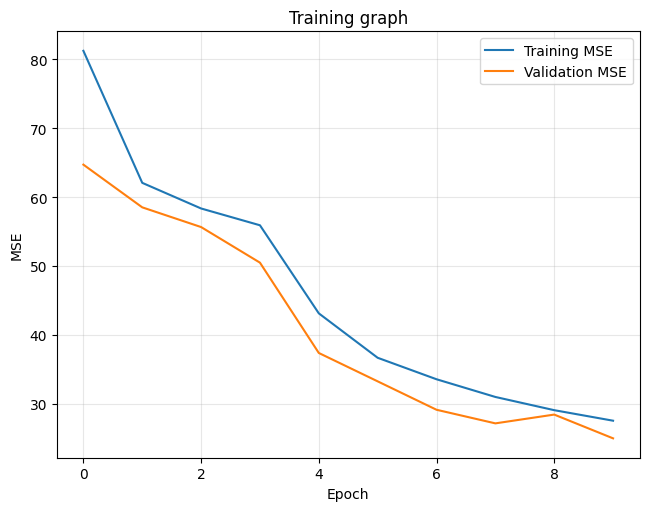

In [80]:
num_features = df.shape[1] - 2  # Exclude date and target column
sequence_length = 24
bert_model = TimeBERT(input_dim=num_features, sequence_length=sequence_length)

trained_bertmodel = train_model(bert_model, train_loader, test_loader, 10)

In [2]:
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 8)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)

    model = SimpleRNN(num_inputs=6, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    for epoch in range(10):
        model.train()
        for inputs, preds in train_loader:

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), preds)
            loss.backward()
            optimizer.step()

        mse = []

        for inputs, preds in test_loader:
            outputs = model(inputs)
            mse.append(criterion(outputs.squeeze(), preds).item())
        
    
    return (np.mean(mse))

In [5]:
import logging
import os
import optuna
import sys
import sqlite3

optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler(sys.stdout))

# Define the path to the SQLite database
storage_directory = '../models/hyperparameter optimization'

# Create or load the study
study_name = "rnn_hyperparameter_optimization"

db_file_path = os.path.join(storage_directory, f'{study_name}.db')
storage_name = f'sqlite:///{os.path.join(storage_directory, f"{study_name}.db")}'

if not os.path.isfile(db_file_path):
    conn = sqlite3.connect(db_file_path)
    conn.close()

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True, 
    direction="minimize"
)
print(storage_name)

if not os.path.exists(db_file_path):
    study.optimize(objective, n_trials=16, n_jobs=2)

# Print best results
print("Best hyperparameters:", study.best_params)
print("Best trial MSE:", study.best_value)

[I 2024-11-20 18:58:57,281] Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.


Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.
Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.
Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.
Using an existing study with name 'rnn_hyperparameter_optimization' instead of creating a new one.
sqlite:///../models/hyperparameter optimization\rnn_hyperparameter_optimization.db
Best hyperparameters: {'hidden_size': 105, 'num_layers': 3, 'dropout': 0.2970317684831742}
Best trial MSE: 30.8786673677077


In [ ]:
params = study.best_params
hp_optim_model = SimpleRNN(num_inputs=6, hidden_size=params['hidden_size'], num_layers=params['num_layers'], dropout=params['dropout'])

trained_hp_model = train_model(hp_optim_model, train_loader, test_loader, 10)

In [ ]:
def model_evaluation(models, dataloader):

    def smape(pred, actual):
        return 100 * torch.mean(2 * torch.abs(pred - actual) / (torch.abs(pred) + torch.abs(actual) + 1e-8)).item()

    def r2_score(pred, actual):
        ss_total = torch.sum((actual - torch.mean(actual)) ** 2)
        ss_residual = torch.sum((actual - pred) ** 2)
        return (1 - ss_residual / ss_total).item()

    model_names = [model.__class__.__name__ for model in models]
    result_df = pd.DataFrame(columns=(['Metric'] + model_names))
    rows = []

    metrics = {
        'MSE': nn.MSELoss(),          # Mean Squared Error
        'MAE': nn.L1Loss(),           # Mean Absolute Error
        'SMAPE': smape,               # Symmetric Mean Absolute Percentage Error
        'R2': r2_score                # R-squared Score
    }

    for metric_name, metric_fn in metrics.items():
        row = {'Metric': metric_name}

        for model in models:
            model.eval()  
            preds = []
            actuals = []

            with torch.no_grad():
                for sequences, targets in dataloader: 
                    if model == 'BaselineModel':
                        preds.append(targets[:-1])
                        actuals.append(targets[1:])
                    else:
                        outputs = model(sequences)  # Get predictions
                        preds.append(outputs.squeeze())  # Squeeze for 1D compatibility
                        actuals.append(targets)

            preds = torch.cat(preds, dim=0)
            actuals = torch.cat(actuals, dim=0)

            # Compute metric
            row[model.__class__.__name__] = metric_fn(preds, actuals)

            if isinstance(row[model.__class__.__name__], torch.Tensor):
                row[model.__class__.__name__] = row[model.__class__.__name__].item()


        rows.append(row)  # Add the row to the list

    # Create a DataFrame from the list of rows
    result_df = pd.DataFrame(rows)
    return result_df

models = [baseline_model, trained_model, gru_model_trained, trained_lstm, trained_stacked_rnn, trained_hp_model, trained_bertmodel]

result_df = model_evaluation(models, test_loader)